# Cross Validation of NMF

Perform cross-validation for NMF.

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os

sns.set("talk", "ticks", palette='colorblind')

In [2]:
import nonnegfac.nnls

## Write the Nonnegative Matrix Factorization Code that can handle missing data

In [3]:
from nonnegfac.nnls import nnlsm_blockpivot as nnlstsq

def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    if A.ndim == 1:
        A = A[:, None]
        
    rhs = np.dot(A.T, M * B).T[:, :, None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    
    return X.T

def cv_nmf(data, rank, M=None, p_holdout=0.3, tol=0.001, verbose=False, max_iter=50):
    """Perform cross-validation for NMF using a speckled holdout pattern.
    
    This code was adapted from Alex Williams at Stanford (https://bit.ly/2KDqKoW).
    
    Args
    ----
    data (ndarray)    : m x n matrix (original data/time-series)
    rank (int)        : the desired output rank (i.e. number of factors)
    M (ndarray)       : m x n binary matrix where zeroes indicate missing/heldout values 
    p_holdout (float) : all random data under this value will be set to False
    tol (float)       : the tolerance for convergence - the solution has converged when 
                        the MSE of subsequent iterations are less than this number
    verbose (bool)    : if True, print out debugging information
    max_itr (int)     : the maximum number of iterations for convergence
    
    Returns
    -------
    U (ndarray)       : 
    Vt (ndarray)      :
    train_err (float) :
    test_err (float)  :
    converged (bool)  :
    
    """   
    # create the masking matrix to decide which values to "hold out"
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout
        
        # check to make sure there are enough values in each row to avoid singular matrix issues
        if M.sum(axis=0).any() < rank:
            for i in range(M.shape[0]):
                if M[i].sum() < rank:
                    M[i, :] = [True]*M.shape[1]
    
    # initialize U randomly
    U = np.random.rand(data.shape[0], rank)

    # init the mean err
    mse = 100
    
    # fit NMF
    for itr in range(max_iter):
        Vt = censored_nnlstsq(U, data, M)
        U = censored_nnlstsq(Vt.T, data.T, M.T).T
        
        # calculate the current iterations mean squared error
        tmp_mse = np.mean((np.dot(U, Vt) - data)**2)
        diff = mse - tmp_mse
          
        # break out of the loop if converged
        if abs(diff) <= tol:
            converged = True
            break
        else:
            mse = tmp_mse
            converged = False
    
    if verbose:
        train_pct = 100 * M.sum() / M.size
        print ("\tIter {} = {:.5f}".format(itr+1, diff))
        print ("\tTrain/Test = {:.2f}/{:.2f}".format(train_pct, 100-train_pct))
        
    # return the result and the train/test error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
        
    return U, Vt, train_err, test_err, converged

### Let's try an example...

In [4]:
N, R = 150, 4

noise = 0.8
replicates = 10

ranks = np.arange(1, 8)

# initialize the problem
U = np.random.rand(N, R) # (150, 4)
Vt = np.random.rand(R, N) # (4, 150)

# create the data by making it noisy
data = np.dot(U, Vt) + noise * np.random.rand(N, N) # (150, 150)

frame = pd.DataFrame()

# fit the models
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te, converged = cv_nmf(data, rnk, verbose=False)[2:]
    
    if converged:
        frame = frame.append([
            {"Rank": rnk, "MSE": tr, "Group": "Train"},
            {"Rank": rnk, "MSE": te, "Group": "Test"},
        ], ignore_index=True)
    else:
        print ("there was a convergence issue: {}".format(rnk))
        
frame["Rank"] = frame["Rank"].astype(np.int32)

# prepare for plotting
groups = frame.groupby(["Group", "Rank"]).describe(percentiles=[0.05, 0.95])

/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm

/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([
/var/folders/d3/z1hh03l929gdlgfh23vm

/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/1768026955.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


In [5]:
groups

MSE                                                              \
           count      mean       std       min        5%       50%       95%   
Group Rank                                                                     
Test  1     10.0  0.075275  0.000872  0.074359  0.074397  0.075009  0.076616   
      2     10.0  0.069775  0.001113  0.068478  0.068631  0.069633  0.071658   
      3     10.0  0.063336  0.000766  0.061469  0.062114  0.063605  0.064044   
      4     10.0  0.058378  0.000716  0.057078  0.057378  0.058402  0.059349   
      5     10.0  0.059989  0.000528  0.058961  0.059116  0.060095  0.060580   
      6     10.0  0.061717  0.000521  0.061109  0.061111  0.061560  0.062382   
      7     10.0  0.063708  0.001380  0.061423  0.061766  0.063583  0.065714   
Train 1     10.0  0.072663  0.000357  0.072045  0.072079  0.072836  0.072983   
      2     10.0  0.064597  0.000502  0.063716  0.063923  0.064604  0.065212   
      3     10.0  0.056462  0.000700  0.055790  0.055797  0.056360  0.057550   
      4     10.0  0.049943  0.000212  0.049652  0.049699  0.049908  0.050269   
      5     10.0  0.048191  0.000274  0.047757  0.047849  0.048153  0.048614   
      6     10.0  0.046787  0.000181  0.046573  0.046580  0.046756  0.047053   
      7     10.0  0.045358  0.000532  0.044622  0.044706  0.045378  0.046028   

                      
                 max  
Group Rank            
Test  1     0.076737  
      2     0.072180  
      3     0.064178  
      4     0.059422  
      5     0.060839  
      6     0.062471  
      7     0.065876  
Train 1     0.072989  
      2     0.065252  
      3     0.058048  
      4     0.050366  
      5     0.048683  
      6     0.047069  
      7     0.046050

### Plot the results

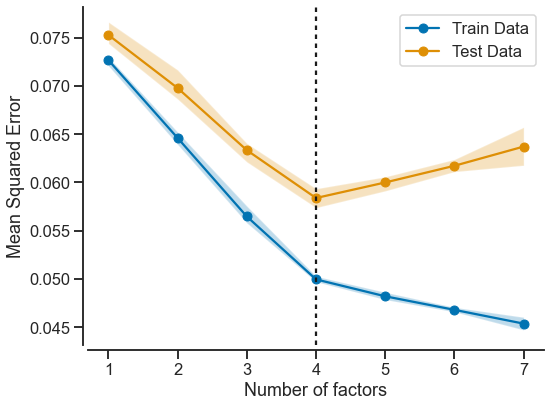

In [6]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.plot(groups["MSE"]["mean"]["Train"], 'o-', label="Train Data")
ax.plot(groups["MSE"]["mean"]["Test"], 'o-', label="Test Data")

ax.fill_between(groups["MSE"]["5%"]["Train"].index, groups["MSE"]["5%"]["Train"], 
                groups["MSE"]["95%"]["Train"], alpha=0.25)
ax.fill_between(groups["MSE"]["5%"]["Test"].index, groups["MSE"]["5%"]["Test"],
                groups["MSE"]["95%"]["Test"], alpha=0.25)

inflection = (groups["MSE"]["mean"]["Test"] > groups["MSE"]["mean"]["Test"].shift()).idxmax() - 1

ax.axvline(inflection, color='k', dashes=[2, 2])

sns.despine(offset=5)
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Number of factors")
ax.legend()
plt.tight_layout()

fig.savefig("Example 4 Factor Solution.png", dpi=350)

## The fun part - Let's try this on our Data

In [7]:
from nonnegfac.nnls import nnlsm_blockpivot as nnlstsq

def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    if A.ndim == 1:
        A = A[:, None]
        
    rhs = np.dot(A.T, M * B).T[:, :, None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    
    return X.T

def cv_nmf(data, rank, M=None, p_holdout=0.3, tol=0.001, verbose=False, max_iter=50):
    """Perform cross-validation for NMF using a speckled holdout pattern.
    
    This code was adapted from Alex Williams at Stanford (https://bit.ly/2KDqKoW).
    
    Args
    ----
    data (ndarray)    : m x n matrix (original data/time-series)
    rank (int)        : the desired output rank (i.e. number of factors)
    M (ndarray)       : m x n binary matrix where zeroes indicate missing/heldout values 
    p_holdout (float) : all random data under this value will be set to False
    tol (float)       : the tolerance for convergence - the solution has converged when 
                        the MSE of subsequent iterations are less than this number
    verbose (bool)    : if True, print out debugging information
    max_itr (int)     : the maximum number of iterations for convergence
    
    Returns
    -------
    U (ndarray)       : 
    Vt (ndarray)      :
    train_err (float) :
    test_err (float)  :
    converged (bool)  :
    
    """   
    # create the masking matrix to decide which values to "hold out"
    
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout
        
        # check to make sure there are enough values in each row to avoid singular matrix issues
        # iterate over each row, and if the row contains less True values than rank
            # turn that row to all True values
        '''
        if M.sum(axis=0).any() < rank:
            for i in range(M.shape[0]):
                if M[i].sum() < rank:
                    M[i, :] = [True]*M.shape[1]
        '''
    # initialize U randomly
    U = np.random.rand(data.shape[0], rank)

    # init the mean err
    mse = 100
    
    # fit NMF
    for itr in range(max_iter):
        Vt = censored_nnlstsq(U, data, M)
        U = censored_nnlstsq(Vt.T, data.T, M.T).T
        
        # calculate the current iterations mean squared error
        tmp_mse = np.mean((np.dot(U, Vt) - data)**2)
        diff = mse - tmp_mse
          
        # break out of the loop if converged
        if abs(diff) <= tol:
            converged = True
            break
        else:
            mse = tmp_mse
            converged = False
    
    if verbose:
        train_pct = 100 * M.sum() / M.size
        print ("\tIter {} = {:.5f}".format(itr+1, diff))
        print ("\tTrain/Test = {:.2f}/{:.2f}".format(train_pct, 100-train_pct))
        
    # return the result and the train/test error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
        
    return U, Vt, train_err, test_err, converged

In [8]:
input_file = 'final/MOD-00067.final2.csv'

df = pd.read_csv(input_file).set_index("timestamp_local")

#Columns to include in the analysis is bin 0 to bin 5 as well as gases #bins 0-5 represent PM2.5. 0-2 represent PM1
COLS_TO_INCLUDE = []
for i in range(6):   
    COLS_TO_INCLUDE.append('bin'+str(i))
COLS_TO_INCLUDE.append('co')
COLS_TO_INCLUDE.append('no')
COLS_TO_INCLUDE.append('no2')
COLS_TO_INCLUDE.append('o3')
COLS_TO_INCLUDE.append('co2')

df = df.dropna(subset=COLS_TO_INCLUDE)[COLS_TO_INCLUDE].sample(frac=0.15)

df = df / df.max().max()

df.head(2)
#df.values


,bin0,bin1,bin2,bin3,bin4,bin5,co,no,no2,o3,co2
timestamp_local,,,,,,,,,,,
10/30/22 21:19,0.001961,0.000228,0.000036,0.000006,0.000006,0.000004,0.041458,0.000142,0.001299,0.000213,0.041098
7/22/22 11:58,0.007114,0.000856,0.000115,0.000018,0.000021,0.000022,0.071020,0.000280,0.003819,0.002676,0.044227


In [9]:
replicates = 3

ranks = np.arange(1, 6)

frame = pd.DataFrame()

# fit the models
for rnk, j in itertools.product(ranks, range(replicates)):
    print ("Rank {}.{}".format(rnk, j))
    
    tr, te, converged = cv_nmf(df.values, rnk, verbose=True, tol=1e-4, max_iter=150, p_holdout=0.10)[2:]
    
    if not converged:
        print ("there was a convergence issue: {}".format(rnk))
    frame = frame.append([
        {"Rank": rnk, "MSE": tr, "Group": "Train", "Converged": converged},
        {"Rank": rnk, "MSE": te, "Group": "Test", "Converged": converged},
    ], ignore_index=True)

frame["Rank"] = frame["Rank"].astype(np.int32)

# prepare for plotting
groups = frame.groupby(["Group", "Rank"]).describe(percentiles=[0.05, 0.95])

Rank 1.0
	Iter 2 = 0.00001
	Train/Test = 89.95/10.05
Rank 1.1


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00001
	Train/Test = 89.98/10.02
Rank 1.2


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00001
	Train/Test = 89.84/10.16
Rank 2.0


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 89.99/10.01
Rank 2.1


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 89.96/10.04
Rank 2.2


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 89.92/10.08
Rank 3.0


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00005
	Train/Test = 89.91/10.09
Rank 3.1


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00005
	Train/Test = 90.08/9.92
Rank 3.2


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 90.04/9.96
Rank 4.0


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 90.00/10.00
Rank 4.1


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 89.95/10.05
Rank 4.2


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 89.98/10.02
Rank 5.0


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00005
	Train/Test = 89.97/10.03
Rank 5.1


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 89.99/10.01
Rank 5.2


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


	Iter 2 = 0.00004
	Train/Test = 90.04/9.96


/var/folders/d3/z1hh03l929gdlgfh23vm9h0c0000gp/T/ipykernel_93024/427321228.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame = frame.append([


In [10]:
groups

MSE                                                        \
           count      mean           std       min        5%       50%   
Group Rank                                                               
Test  1      3.0  0.000266  1.579548e-05  0.000249  0.000251  0.000270   
      2      3.0  0.000231  2.068333e-05  0.000208  0.000211  0.000237   
      3      3.0  0.000232  4.339968e-05  0.000182  0.000190  0.000256   
      4      3.0  0.000241  1.895426e-05  0.000225  0.000226  0.000236   
      5      3.0  0.000217  3.777828e-05  0.000173  0.000180  0.000237   
Train 1      3.0  0.000047  8.805733e-08  0.000047  0.000047  0.000047   
      2      3.0  0.000012  2.127093e-07  0.000012  0.000012  0.000012   
      3      3.0  0.000011  1.861707e-07  0.000011  0.000011  0.000011   
      4      3.0  0.000011  2.433610e-07  0.000010  0.000010  0.000010   
      5      3.0  0.000010  5.815404e-07  0.000009  0.000009  0.000010   

                                
                 95%       max  
Group Rank                      
Test  1     0.000279  0.000280  
      2     0.000247  0.000249  
      3     0.000258  0.000259  
      4     0.000259  0.000262  
      5     0.000241  0.000241  
Train 1     0.000047  0.000047  
      2     0.000012  0.000012  
      3     0.000011  0.000011  
      4     0.000011  0.000011  
      5     0.000010  0.000010

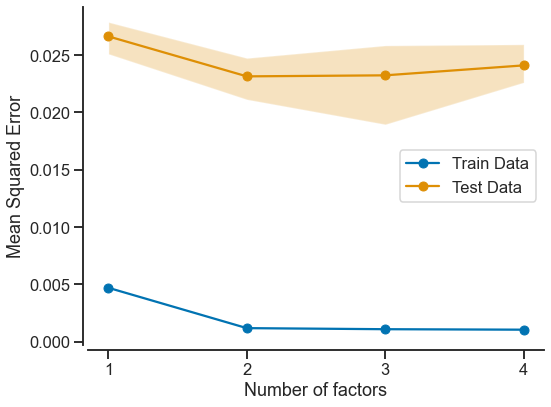

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 6))

scalar = 100

ax.plot(groups["MSE"]["mean"]["Train"][:-1]*scalar, 'o-', label="Train Data")
ax.plot(groups["MSE"]["mean"]["Test"][:-1]*scalar, 'o-', label="Test Data")

ax.fill_between(groups["MSE"]["5%"]["Train"].index[:-1], groups["MSE"]["5%"]["Train"][:-1]*scalar, 
                groups["MSE"]["95%"]["Train"][:-1]*scalar, alpha=0.25)
ax.fill_between(groups["MSE"]["5%"]["Test"].index[:-1], groups["MSE"]["5%"]["Test"][:-1]*scalar,
                groups["MSE"]["95%"]["Test"][:-1]*scalar, alpha=0.25)

inflection = (groups["MSE"]["mean"]["Test"] > groups["MSE"]["mean"]["Test"].shift()).idxmax() - 1
#ax.axvline(3, color='k', dashes=[2, 2])

sns.despine(offset=5)
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Number of factors")
ax.legend()
plt.tight_layout()

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels([1, 2, 3, 4])

fig.savefig("CV_1e-3-max_iter200_original.png", dpi=350)
